# Импорт

In [ ]:
!pip install swig > /dev/null 2>&1
!pip install "gymnasium[box2d]"  > /dev/null 2>&1
!pip install --upgrade pyvirtualdisplay ipykernel > /dev/null 2>&1

In [ ]:
# Импорты основных библиотек
import gymnasium as gym  # библиотека для работы с окружениями
import numpy as np       # библиотека для работы с массивами
import torch             # фреймворк для глубокого обучения
import torch.nn as nn           # Модуль для создания нейронных сетей
import torch.optim as optim     # Оптимизаторы
import torch.nn.functional as F # Функции активации и потерь

import copy                     # Для создания глубоких копий объектов
from collections import deque   # Для реализации буфера опыта
import random                   # Для случайной выборки из буфера

# Модули для отображения видео в Google Colab
from IPython import display as ipythondisplay
from gym.wrappers import RecordVideo
import os
import base64

import matplotlib.pyplot as plt
from IPython.display import display, clear_output

from torch.distributions import Categorical

#DDPG

In [ ]:
# Определение архитектуры актера
class Actor(nn.Module):
    def __init__(self, state_dim, action_dim, max_action):
        super(Actor, self).__init__()
        self.max_action = max_action

        # Нейронная сеть актора принимает состояние и выдает действие
        # Архитектура: state_dim -> 400 -> 300 -> action_dim
        # Функция активации: ReLU для скрытых слоев, Tanh для выходного
        # Выход масштабируется на max_action

        # Определение слоев нейронной сети актера
        self.net = nn.Sequential(
            nn.Linear(state_dim, 400),    # входной слой
            nn.ReLU(),                    # функция активации
            nn.Linear(400, 300),          # скрытый слой
            nn.ReLU(),                    # функция активации
            nn.Linear(300, action_dim),   # выходной слой
            nn.Tanh()                     # функция активации для нормализации выхода [-1,1]
        )

    def forward(self, state):
        # Прямой проход через сеть с масштабированием выхода
        return self.max_action * self.net(state)

# Определение архитектуры критика
class Critic(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(Critic, self).__init__()

        # Нейронная сеть критика принимает состояние и действие
        # Архитектура: (state_dim + action_dim) -> 400 -> 300 -> 1
        # Выдает Q-значение для пары состояние-действие

        # Определение слоев нейронной сети критика
        self.net = nn.Sequential(
            nn.Linear(state_dim + action_dim, 400),  # входной слой (состояние + действие)
            nn.ReLU(),                               # функция активации
            nn.Linear(400, 300),                     # скрытый слой
            nn.ReLU(),                               # функция активации
            nn.Linear(300, 1)                        # выходной слой (Q-значение)
        )

    def forward(self, state, action):
        # Прямой проход через сеть
        return self.net(torch.cat([state, action], 1))

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  def _forward_input(self, allow_stdin=False):


In [ ]:
# DDPG агент
class DDPGAgent:
    def __init__(self, state_dim, action_dim, max_action):

        # Инициализация основных и целевых сетей
        # Память для experience replay
        # Гиперпараметры: batch_size, gamma (коэффициент дисконтирования),
        # tau (коэффициент мягкого обновления)

        self.actor = Actor(state_dim, action_dim, max_action)
        self.actor_target = copy.deepcopy(self.actor)
        self.actor_optimizer = optim.Adam(self.actor.parameters(), lr=1e-4)

        # Инициализация основной и целевой сети критика
        self.critic = Critic(state_dim, action_dim)
        self.critic_target = copy.deepcopy(self.critic)
        self.critic_optimizer = optim.Adam(self.critic.parameters(), lr=1e-3)

        # Инициализация буфера опыта и гиперпараметров
        self.memory = deque(maxlen=100000)  # буфер опыта
        self.batch_size = 64                # размер батча
        self.gamma = 0.95                    # коэффициент дисконтирования
        self.tau = 0.01                   # коэффициент мягкого обновления

    def select_action(self, state):
        # Преобразование состояния в тензор
        state = torch.FloatTensor(state.reshape(1, -1))

        # Получение действия от актера
        with torch.no_grad():
            return self.actor(state).data.numpy().flatten()

    def train(self):
        # Проверка наличия достаточного количества опыта
        if len(self.memory) < self.batch_size:
            return None, None

        # Выборка случайного батча из памяти
        batch = random.sample(self.memory, self.batch_size)
        state_batch = torch.FloatTensor([s[0] for s in batch])
        action_batch = torch.FloatTensor([s[1] for s in batch])
        reward_batch = torch.FloatTensor([s[2] for s in batch]).unsqueeze(1)
        next_state_batch = torch.FloatTensor([s[3] for s in batch])
        done_batch = torch.FloatTensor([s[4] for s in batch]).unsqueeze(1)

        # Обновление критика
        # Формула: Q_target = r + γ * Q'(s', μ'(s'))
        with torch.no_grad():
            # Вычисление целевого Q-значения
            next_actions = self.actor_target(next_state_batch)
            target_Q = self.critic_target(next_state_batch, next_actions)
            target_Q = reward_batch + (1 - done_batch) * self.gamma * target_Q

        # Вычисление текущего Q-значения
        current_Q = self.critic(state_batch, action_batch)
        # Функция потерь для критика (MSE)
        critic_loss = nn.MSELoss()(current_Q, target_Q.detach())

        # Оптимизация критика
        self.critic_optimizer.zero_grad()
        critic_loss.backward()

        # Клиппинг градиентов для стабильности
        torch.nn.utils.clip_grad_norm_(self.critic.parameters(), 1)  # Добавляем клиппинг градиентов
        self.critic_optimizer.step()

        # Обновление актера
        # Максимизация Q(s,μ(s))
        actor_loss = -self.critic(state_batch, self.actor(state_batch)).mean()

        # Оптимизация актера
        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        torch.nn.utils.clip_grad_norm_(self.actor.parameters(), 1)  # Добавляем клиппинг градиентов
        self.actor_optimizer.step()

        # Мягкое обновление целевых сетей
        # θ' = τθ + (1-τ)θ'
        for param, target_param in zip(self.critic.parameters(), self.critic_target.parameters()):
            target_param.data.copy_(self.tau * param.data + (1 - self.tau) * target_param.data)

        for param, target_param in zip(self.actor.parameters(), self.actor_target.parameters()):
            target_param.data.copy_(self.tau * param.data + (1 - self.tau) * target_param.data)

        return actor_loss.item(), critic_loss.item()

## Вариант улучшения

Класс Replay Buffer представляет собой воспроизведение опыта, позволяющий записывать лучшие действия и воспроизводить их на последующих эпизодах. Это значительно повышает качество обучения, но имеет свои недостатки:

 1) Значительное увеличение времени обучения (около 8 часов на CPU)

 2) Затраты памяти

In [ ]:
# # Replay Buffer for storing experience
# class ReplayBuffer:
#     def __init__(self, max_size=1e6):
#         self.storage = []
#         self.max_size = max_size
#         self.ptr = 0

#     def add(self, transition):
#         state, action, next_state, reward, done = transition
#         state = np.array(state, dtype=np.float32)
#         next_state = np.array(next_state, dtype=np.float32)
#         action = np.array(action, dtype=np.float32)  # Ensure action is of type float32
#         reward = float(reward)  # Ensure reward is a scalar float
#         done = float(done)  # Ensure done is a scalar float
#         self.storage.append((state, action, next_state, reward, done))
#         if len(self.storage) > self.max_size:
#             self.storage.pop(0)

#     def sample(self, batch_size):
#         ind = np.random.randint(0, len(self.storage), size=batch_size)
#         state, action, next_state, reward, done = [], [], [], [], []

#         for i in ind:
#             s, a, s2, r, d = self.storage[i]
#             state.append(np.array(s, copy=False))
#             action.append(np.array(a, copy=False))
#             next_state.append(np.array(s2, copy=False))
#             reward.append(np.array(r, copy=False))
#             done.append(np.array(1.0 - d, copy=False))

#         return (
#             np.array(state),
#             np.array(action),
#             np.array(next_state),
#             np.array(reward).reshape(-1, 1),
#             np.array(done).reshape(-1, 1),
#         )

## Инициализация среды

In [ ]:
env = gym.make("BipedalWalker-v3", render_mode='rgb_array')
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.shape[0]
max_action = float(env.action_space.high[0])

<frozen importlib._bootstrap>:241: DeprecationWarning: builtin type SwigPyPacked has no __module__ attribute
<frozen importlib._bootstrap>:241: DeprecationWarning: builtin type SwigPyObject has no __module__ attribute
<frozen importlib._bootstrap>:241: DeprecationWarning: builtin type swigvarlink has no __module__ attribute
/usr/local/lib/python3.10/dist-packages/pygame/pkgdata.py:25: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  from pkg_resources import resource_stream, resource_exists
/usr/local/lib/python3.10/dist-packages/pkg_resources/__init__.py:3154: DeprecationWarning: Deprecated call to `pkg_resources.declare_namespace('google')`.
Implementing implicit namespace packages (as specified in PEP 420) is preferred to `pkg_resources.declare_namespace`. See https://setuptools.pypa.io/en/latest/references/keywords.html#keyword-namespace-packages
  declare_namespace(pkg)
/usr/local/lib/python3.10/dist-packages/

## Train DDPG

In [ ]:
# Создание агента
agent = DDPGAgent(state_dim, action_dim, max_action)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  def _forward_input(self, allow_stdin=False):


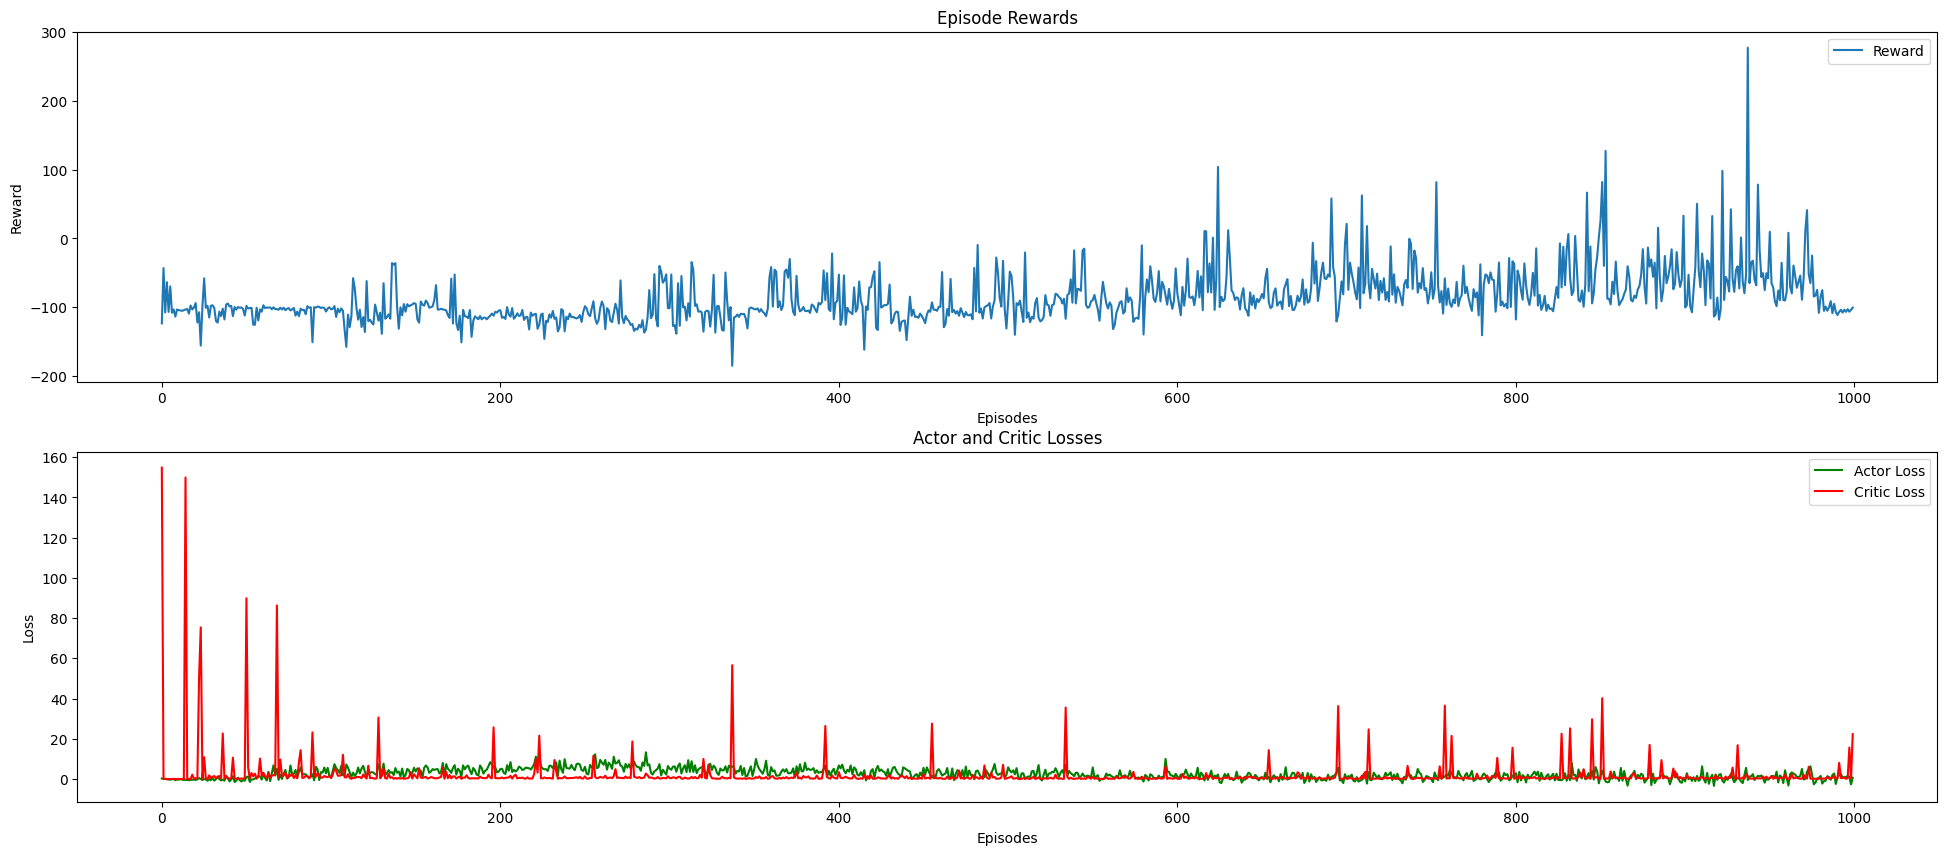

In [ ]:
# Списки для хранения данных
rewards = []
actor_losses = []
critic_losses = []

# Создание графиков
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(24, 10))

# Основной цикл обучения по эпизодам
for episode in range(1000):
    state, _ = env.reset()
    episode_reward = 0

    # Цикл по шагам в эпизоде
    for t in range(1000):
        # Выбор действия и взаимодействие с окружением
        action = agent.select_action(state)
        next_state, reward, done, truncated, _ = env.step(action)

        # Сохранение опыта в памяти
        agent.memory.append((state, action, reward, next_state, float(done)))

        # Обучение агента
        actor_loss, critic_loss = agent.train()

        state = next_state
        episode_reward += reward

        if done or truncated:
            break

    # Сохранение результатов
    rewards.append(episode_reward)
    if actor_loss is not None and critic_loss is not None:
        actor_losses.append(actor_loss)
        critic_losses.append(critic_loss)

    # Очистка и обновление графиков
    clear_output(wait=True)
    ax1.clear()
    ax2.clear()

    ax1.set_title('Episode Rewards')
    ax1.set_xlabel('Episodes')
    ax1.set_ylabel('Reward')
    ax1.plot(rewards, label='Reward')
    ax1.legend()

    ax2.set_title('Actor and Critic Losses')
    ax2.set_xlabel('Episodes')
    ax2.set_ylabel('Loss')
    ax2.plot(actor_losses, label='Actor Loss', color='green')
    ax2.plot(critic_losses, label='Critic Loss', color='red')
    ax2.legend()

    display(fig)

# После завершения обучения
clear_output(wait=True)
plt.show()

## Анализ результатов

### Средняя награда

In [ ]:
# Анализ результатов
avg_reward_all = sum(rewards) / len(rewards)
avg_reward_last_100 = sum(rewards[-100:]) / min(len(rewards), 100)

print(f"Средняя награда за все эпизоды: {avg_reward_all:.2f}")
print(f"Средняя награда за последние 100 эпизодов: {avg_reward_last_100:.2f}")

Средняя награда за все эпизоды: -86.32
Средняя награда за последние 100 эпизодов: -61.15


Средняя награда за последние 100 эпизодов показывает улучшение по сравнению со средней наградой за весь процесс обучения. Это свидетельствует о прогрессе агента и его адаптации к среде, хотя он всё ещё демонстрирует недостаточно качественную стратегию управления.

### Дисперсия

Дисперсия за последние 100 эпизодов: 2970.54


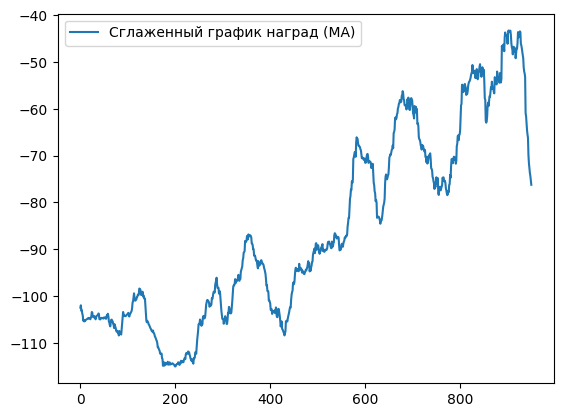

In [ ]:
# Скользящее среднее награды
def moving_average(data, window_size=100):
    return np.convolve(data, np.ones(window_size)/window_size, mode='valid')

# Дисперсия награды за последние N эпизодов
reward_variance_last_n = np.var(rewards[-100:])
print(f"Дисперсия за последние 100 эпизодов: {reward_variance_last_n:.2f}")

# Сглаженный график награды
smoothed_rewards = moving_average(rewards, window_size=50)
plt.plot(smoothed_rewards, label='Сглаженный график наград (MA)')
plt.legend()
plt.show()

Высокая дисперсия награды за последние 100 эпизодов говорит о нестабильности поведения агента.

График MA показывает, что идёт не стабильный рост награды со временем

### Сходиомсть

In [ ]:
avg_reward_target = 300  # Пороговая награда
convergence_episode = next((i for i, avg in enumerate(moving_average(rewards, 100)) if avg > avg_reward_target), None)
if convergence_episode:
    print(f"Сходимость достигнута на эпизоде: {convergence_episode}")
else:
    print("Сходимость не была достигнута на всём процессе обучения.")

Сходимость не была достигнута на всём процессе обучения.


Отсутствие сходимости указывает на то, что агент в процессе обучения так и не смог стабильно демонстрировать поведение, соответствующее пороговому уровню.

### Наклон тренда обучения

In [ ]:
from sklearn.linear_model import LinearRegression

# Линейный тренд
episodes = np.arange(len(rewards)).reshape(-1, 1)
rewards_array = np.array(rewards).reshape(-1, 1)
model = LinearRegression().fit(episodes, rewards_array)
trend_slope = model.coef_[0][0]  # Наклон линии
print(f"Наклон тренда: {trend_slope:.2f}")
if trend_slope < 0.01:
    print("Стратегия стабилизирована. Обучение проходит хорошо.")
else:
    print("Стратегия не найдена. Обучение не показало хороших результатов")

Наклон тренда: 0.06
Стратегия не найдена. Обучение не показало хороших результатов


Этот наклон показывает, что награды увеличиваются по мере обучения, но прирост остаётся довольно медленным.

### Воспроизведение эпизода

In [ ]:
# Отображение видео в Google Colab
def show_video(video_path):
    """
    Отображение видео в Google Colab.
    """
    video = open(video_path, "rb").read()
    video_encoded = base64.b64encode(video).decode('utf-8')
    video_tag = '<video controls alt="test" src="data:video/mp4;base64,{0}">'.format(video_encoded)
    ipythondisplay.display(ipythondisplay.HTML(data=video_tag))

# Запись видео успешного эпизода с лучшими параметрами
def record_episode(env, policy_net, video_dir="./video"):
    """
    Запись видео успешного эпизода с использованием лучших параметров.
    Возвращает имя созданного файла.
    """
    env = gym.wrappers.RecordVideo(env, video_dir, episode_trigger=lambda x: x == 0)
    state, _ = env.reset()
    total_reward = 0

    while True:
        action = policy_net.select_action(state)
        state, reward, done, truncated, _ = env.step(action)
        total_reward += reward
        if done or truncated:
            break

    env.close()


    video_files = [f for f in os.listdir(video_dir) if f.endswith(".mp4")]
    if video_files:
        latest_file = max(video_files, key=lambda f: os.path.getmtime(os.path.join(video_dir, f)))
        return os.path.join(video_dir, latest_file)
    return None

In [ ]:
# Записываем и показываем видео успешного эпизода
print("\nЗаписываем видео успешного эпизода...")
video_path = record_episode(env, agent)
show_video(video_path)


Записываем видео успешного эпизода...


/usr/local/lib/python3.10/dist-packages/moviepy/config_defaults.py:1: DeprecationWarning: invalid escape sequence '\P'
  """


##Итог DDPG

***Архитектура модели***

Актор (Actor)

Актор представляет собой нейронную сеть, принимающую состояние среды (вектор признаков) и возвращающую действие, нормализованное в диапазоне [-1, 1].

Критик (Critic)

Критик принимает состояние и действие, оценивая Q-значение (ожидаемую награду).

***Алгоритм обучения***

**Основные компоненты агента:**

Основные и целевые сети актера и критика.

Оптимизаторы Adam для актера (с шагом 1e-4) и критика (с шагом 1e-3).

Буфер опыта (Replay Buffer) на 100,000 переходов.

**Гиперпараметры:**

Размер батча: 64.

Коэффициент дисконтирования награды (γ): 0.95.

Коэффициент мягкого обновления целевых сетей (τ): 0.01.

**Обучение агента:**

*Сохранение опыта*

Каждое взаимодействие с окружением записывается в буфер опыта: состояние, действие, награда, следующее состояние, флаг завершения эпизода.

*Обновление критика*

Целевое Q-значение вычисляется как сумма текущей награды и дисконтированного значения от целевой сети критика

Потери для критика рассчитываются по функции MSE между текущими Q-значениями и целевыми.

# PPO

In [ ]:
class PPOAgent:
    def __init__(self, state_dim, action_dim, hidden_dim=64):
        self.actor_mean = nn.Sequential(
            nn.Linear(state_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, action_dim),
        )

        self.actor_log_std = nn.Parameter(torch.zeros(action_dim))  # Логарифм стандартного отклонения для каждого действия

        self.critic = nn.Sequential(
            nn.Linear(state_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, 1)
        )

        self.optimizer_actor = optim.Adam(self.actor_mean.parameters(), lr=3e-4)
        self.optimizer_critic = optim.Adam(self.critic.parameters(), lr=3e-4)

        self.gamma = 0.99
        self.epsilon = 0.2
        self.epochs = 4

    def select_action(self, state):
        state = torch.FloatTensor(state)
        mean = self.actor_mean(state)
        std = torch.exp(self.actor_log_std)  # Преобразование логарифма отклонения в стандартное отклонение
        dist = torch.distributions.Normal(mean, std)
        action = dist.sample()
        action = torch.clamp(action, -1.0, 1.0)  # Ограничиваем действие в пределах [-1, 1]
        return action.numpy(), dist.log_prob(action).sum()

    def update(self, states, actions, old_log_probs, returns, advantages):
        # Преобразование в тензоры, если они еще не являются тензорами
        if not isinstance(states, torch.Tensor):
            states = torch.FloatTensor(states)
        if not isinstance(actions, torch.Tensor):
            actions = torch.FloatTensor(actions)
        if not isinstance(old_log_probs, torch.Tensor):
            old_log_probs = torch.FloatTensor(old_log_probs)
        if not isinstance(returns, torch.Tensor):
            returns = torch.FloatTensor(returns)
        if not isinstance(advantages, torch.Tensor):
            advantages = torch.FloatTensor(advantages)

        for _ in range(self.epochs):
            # Обновление критика
            value_pred = self.critic(states).squeeze()
            critic_loss = F.mse_loss(value_pred, returns)

            self.optimizer_critic.zero_grad()
            critic_loss.backward()
            self.optimizer_critic.step()

            # Обновление актора
            mean = self.actor_mean(states)
            std = torch.exp(self.actor_log_std)
            dist = torch.distributions.Normal(mean, std)
            new_log_probs = dist.log_prob(actions).sum(dim=-1)

            ratio = torch.exp(new_log_probs - old_log_probs)

            surr1 = ratio * advantages
            surr2 = torch.clamp(ratio, 1.0 - self.epsilon, 1.0 + self.epsilon) * advantages

            actor_loss = -torch.min(surr1, surr2).mean()

            self.optimizer_actor.zero_grad()
            actor_loss.backward()
            self.optimizer_actor.step()


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  def _forward_input(self, allow_stdin=False):


## PPO train

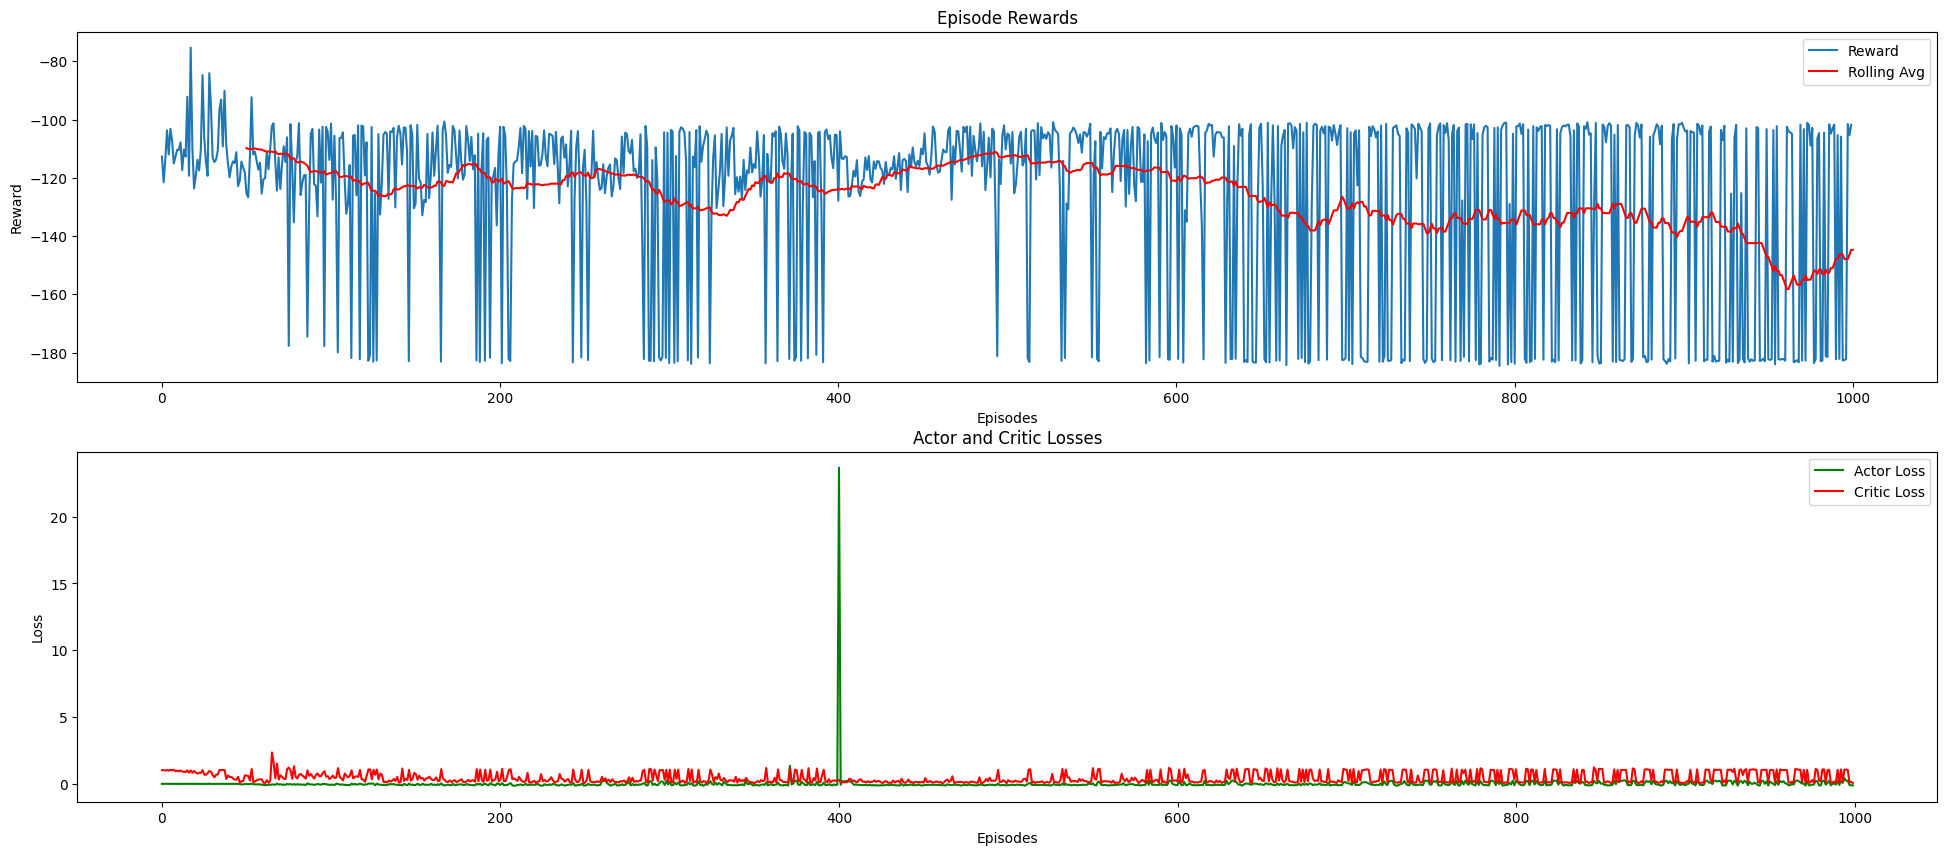

In [ ]:
agent = PPOAgent(state_dim, action_dim)
best_reward = float('-inf')
best_agent = None

rewards_history = []
actor_losses = []
critic_losses = []

# Скользящее среднее для наград
rolling_rewards = deque(maxlen=50)

# Создание графиков
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(24, 10))

for episode in range(1000):
    state, _ = env.reset()
    done = False
    episode_reward = 0

    states = []
    actions = []
    rewards = []
    log_probs = []

    while True:
        action, log_prob = agent.select_action(state)
        next_state, reward, done, truncated, _ = env.step(action)

        states.append(state)
        actions.append(action)
        rewards.append(reward)
        log_probs.append(log_prob.detach())  # Отсоединяем градиенты

        state = next_state
        episode_reward += reward
        if done or truncated:
            break

    rewards_history.append(episode_reward)
    rolling_rewards.append(episode_reward)

    # Преобразование в numpy arrays, затем в тензоры
    states = torch.FloatTensor(np.array(states))
    actions = torch.FloatTensor(np.array(actions))  # Используем float для корректности
    log_probs = torch.stack(log_probs)

    # Вычисление returns и advantages
    returns = []
    R = 0
    for r in reversed(rewards):
        R = r + agent.gamma * R
        returns.insert(0, R)

    returns = torch.FloatTensor(np.array(returns))
    returns = (returns - returns.mean()) / (returns.std() + 1e-8)
    advantages = returns.clone()  # Используем returns как advantages

    # Обновление агента
    actor_loss = None
    critic_loss = None
    for _ in range(agent.epochs):
        value_pred = agent.critic(states).squeeze()
        critic_loss = F.mse_loss(value_pred, returns)
        agent.optimizer_critic.zero_grad()
        critic_loss.backward()
        agent.optimizer_critic.step()

        mean = agent.actor_mean(states)
        std = torch.exp(agent.actor_log_std)
        dist = torch.distributions.Normal(mean, std)
        new_log_probs = dist.log_prob(actions).sum(dim=-1)
        ratio = torch.exp(new_log_probs - log_probs)

        surr1 = ratio * advantages
        surr2 = torch.clamp(ratio, 1.0 - agent.epsilon, 1.0 + agent.epsilon) * advantages
        actor_loss = -torch.min(surr1, surr2).mean()
        agent.optimizer_actor.zero_grad()
        actor_loss.backward()
        agent.optimizer_actor.step()

    actor_losses.append(actor_loss.item())
    critic_losses.append(critic_loss.item())

    if episode_reward > best_reward:
        best_reward = episode_reward
        best_agent = copy.deepcopy(agent)

    # Очистка и обновление графиков
    clear_output(wait=True)
    ax1.clear()
    ax2.clear()

    # Построение графика наград
    ax1.set_title('Episode Rewards')
    ax1.set_xlabel('Episodes')
    ax1.set_ylabel('Reward')
    ax1.plot(rewards_history, label='Reward')

    # Добавление скользящего среднего только если длина истории достаточна
    if len(rewards_history) >= 50:
        rolling_avg = np.convolve(rewards_history, np.ones(50) / 50, mode='valid')
        ax1.plot(range(len(rewards_history) - len(rolling_avg) + 1, len(rewards_history) + 1),
                rolling_avg, label='Rolling Avg', color='red')

    ax1.legend()

    # Построение графиков потерь
    ax2.set_title('Actor and Critic Losses')
    ax2.set_xlabel('Episodes')
    ax2.set_ylabel('Loss')
    ax2.plot(actor_losses, label='Actor Loss', color='green')
    ax2.plot(critic_losses, label='Critic Loss', color='red')
    ax2.legend()

    display(fig)

# Завершение отображения графиков
clear_output(wait=True)
plt.show()

## Анализ результатов

### Средняя награда

In [ ]:
# Вычисление средней награды
avg_reward_all = np.mean(rewards_history)
avg_reward_last_100 = np.mean(rewards_history[-100:]) if len(rewards_history) >= 100 else avg_reward_all

# Вывод результатов
print(f"Средняя награда за все эпизоды: {avg_reward_all:.2f}")
print(f"Средняя награда за последние 100 эпизодов: {avg_reward_last_100:.2f}")

Средняя награда за все эпизоды: -125.99
Средняя награда за последние 100 эпизодов: -145.95


Средняя награда указывает на то, что в процессе обучения наблюдается ухудшение стратегии, так как средняя награда за последние 100 эпизодов стала ниже, чем за все эпизоды

### Дисперсия

Дисперсия за последние 100 эпизодов: 1531.56


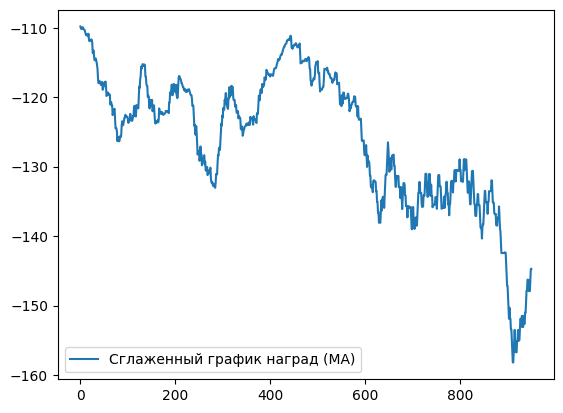

In [ ]:
# Скользящее среднее награды
def moving_average(data, window_size=100):
    return np.convolve(data, np.ones(window_size)/window_size, mode='valid')

# Дисперсия награды за последние N эпизодов
reward_variance_last_n = np.var(rewards_history[-100:])
print(f"Дисперсия за последние 100 эпизодов: {reward_variance_last_n:.2f}")

# Сглаженный график награды
smoothed_rewards = moving_average(rewards_history, window_size=50)
plt.plot(smoothed_rewards, label='Сглаженный график наград (MA)')
plt.legend()
plt.show()

Результаты расчета показывают, что дисперсия награды за последние 100 эпизодов составляет 1531.56, что указывает на значительные колебания в наградах между эпизодами

MA график указывает на ухудшение стабильности обучения со временем

### Сходимость

In [ ]:
avg_reward_target = 300  # Пороговая награда
convergence_episode = next((i for i, avg in enumerate(moving_average(rewards, 100)) if avg > avg_reward_target), None)
if convergence_episode:
    print(f"Сходимость достигнута на эпизоде: {convergence_episode}")
else:
    print("Сходимость не была достигнута на всём процессе обучения.")

Сходимость не была достигнута на всём процессе обучения.


### Воспроизведение эпизода

In [ ]:
# Отображение видео в Google Colab
def show_video(video_path):
    """
    Отображение видео в Google Colab.
    """
    video = open(video_path, "rb").read()
    video_encoded = base64.b64encode(video).decode('utf-8')
    video_tag = '<video controls alt="test" src="data:video/mp4;base64,{0}">'.format(video_encoded)
    ipythondisplay.display(ipythondisplay.HTML(data=video_tag))

# Запись видео успешного эпизода с лучшими параметрами
def record_episode(env, policy_net, video_dir="./video"):
    """
    Запись видео успешного эпизода с использованием лучших параметров.
    Возвращает имя созданного файла.
    """
    env = gym.wrappers.RecordVideo(env, video_dir, episode_trigger=lambda x: x == 0)
    state, _ = env.reset()
    total_reward = 0

    while True:
        action, _ = policy_net.select_action(state)
        state, reward, done, truncated, _ = env.step(action)
        total_reward += reward
        if done or truncated:
            break

    env.close()


    video_files = [f for f in os.listdir(video_dir) if f.endswith(".mp4")]
    if video_files:
        latest_file = max(video_files, key=lambda f: os.path.getmtime(os.path.join(video_dir, f)))
        return os.path.join(video_dir, latest_file)
    return None

In [ ]:
# Записываем и показываем видео успешного эпизода
print("\nЗаписываем видео с лучшим агентом...")
video_path = record_episode(env, best_agent)
show_video(video_path)


Записываем видео с лучшим агентом...


/usr/local/lib/python3.10/dist-packages/gymnasium/wrappers/rendering.py:283: UserWarning: WARN: Overwriting existing videos at /content/video folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


## Вариант улучшения

In [ ]:
# class ReplayBuffer:
#     def __init__(self, capacity):
#         """
#         Инициализация буфера опыта.
#         :param capacity: максимальный размер буфера.
#         """
#         self.buffer = deque(maxlen=capacity)

#     def store(self, state, action, log_prob, reward, next_state, done):
#         """
#         Сохранение перехода в буфер.
#         """
#         self.buffer.append((state, action, log_prob, reward, next_state, done))

#     def sample(self, batch_size):
#         """
#         Выбор случайного батча из буфера.
#         """
#         batch = random.sample(self.buffer, batch_size)
#         states, actions, log_probs, rewards, next_states, dones = zip(*batch)

#         return (
#             torch.FloatTensor(states),
#             torch.FloatTensor(actions),
#             torch.FloatTensor(log_probs),
#             torch.FloatTensor(rewards),
#             torch.FloatTensor(next_states),
#             torch.FloatTensor(dones)
#         )

#     def size(self):
#         """
#         Текущий размер буфера.
#         """
#         return len(self.buffer)

# replay_buffer = ReplayBuffer(capacity=10000)

# state, _ = env.reset()
# done = False

# while not done:
#     action, log_prob = agent.select_action(state)
#     next_state, reward, done, truncated, _ = env.step(action)

#     replay_buffer.store(state, action, log_prob, reward, next_state, done)
#     state = next_state

# if replay_buffer.size() >= batch_size:
#     states, actions, log_probs, rewards, next_states, dones = replay_buffer.sample(batch_size)

#     # Вычисляем returns и advantages
#     returns = []
#     R = 0
#     for r, d in zip(reversed(rewards), reversed(dones)):
#         R = r + agent.gamma * R * (1 - d)  # Обнуляем накопление награды при завершении эпизода
#         returns.insert(0, R)

#     returns = torch.FloatTensor(returns)
#     returns = (returns - returns.mean()) / (returns.std() + 1e-8)
#     advantages = returns.clone()  # Используем returns как advantages

#     # Обновление агента
#     agent.update(states, actions, log_probs, returns, advantages)


## Итог PPO

Actor редсказывает среднее значение действий (actor_mean) и их логарифм стандартного отклонения (actor_log_std) для параметризации нормального распределения.

Critic оценивает ценность состояния для вычисления целевых значений (returns) и преимущества (advantages).

***Алгоритм обучения***

**В каждом эпизоде:**

Агент взаимодействует со средой, сохраняя состояния, действия, награды и вероятности.

Вычисляются целевые значения (returns) и преимущества (advantages).

Актор и критик обновляются несколько раз с использованием сохранённых данных.

Скользящее среднее наград используется для оценки прогресса.

**Метрики и визуализация:**

Награды за эпизоды.

Скользящее среднее наград (для выявления тренда).

Потери актора и критика.

#Сравнение

**DDPG:**

Использует метод опытного реплея для обучения на старых данных, что позволяет повышать стабильность, но требует большого объема памяти.

Обновления происходят с использованием целевых сетей для предотвращения нестабильности.

Использует метод градиента для обучения сети актора и критика.

Сложнее в настройке из-за большого числа гиперпараметров и необходимости применения опытного реплея.

Может требовать больше вычислительных ресурсов для поддержания опыта в памяти и вычисления целевых сетей.

**PPO:**

Использует метод клипов (clipping) для обновления политики, что ограничивает изменение на каждом шаге. Это предотвращает большие шаги и делает обучение более стабильным.

Проводит несколько шагов обновления на каждом мини-батче, что улучшает стабильность.

Для улучшения обучения использует разделение на мини-батчи.

Проще в использовании. Это один из наиболее простых и популярных методов в современных задачах обучения с подкреплением.

Легче настроить и применить на практике, так как не требует хранения большого объема данных или сложных сетевых структур.